In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D
from csbdeep.utils import Path, normalize
from tifffile import imread
from glob import glob
from tracking_utils import plot_img_label, random_fliprot, random_intensity_change, augmenter
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) # this goes *before* tf import
import tensorflow as tf
np.random.seed(42)
lbl_cmap = random_label_cmap()
from tracking_utils import *
import trackpy as tp
import pandas as pd
%matplotlib ipympl
import scipy
import sklearn
import random

import yupi.stats as ys
from yupi import Trajectory, WindowType, DiffMethod
def get_trajs(nDrops, trajs, fps, subsample_factor):
    Trajs = []
    for i in range(0, nDrops):
        p = trajs.loc[trajs.particle == i, ['x','y']][::subsample_factor]
        Trajs.append(Trajectory(p.x, p.y, dt = 1/fps*subsample_factor, traj_id=i, diff_est={'method':DiffMethod.LINEAR_DIFF, 
                                                                                  'window_type': WindowType.CENTRAL}))
    return Trajs

In [2]:
run_detection_verb = False
run_linking_verb = False

In [3]:
resolution = 1000
sc = int(resolution/500)
fps = 100
simulated_trajectories = pd.read_parquet(f'./simulation/simulated_trajectories_{fps}_fps_r_decay_r_gaussian_2.parquet')
imgs_path = f'./simulation/synthetic_dataset_{fps}_fps_r_decay_r_gaussian_2/image/'
frames = np.arange(0, 70000, 1)

simulated_trajectories = pd.read_parquet(f'./simulation/simulated_trajectories_100_fps_r_decay_r_gaussian_2.parquet')
simulated_trajectories = simulated_trajectories.loc[simulated_trajectories.frame < 70000]
simulated_trajectories['particle'] = simulated_trajectories['label']
# offset the simulated trajectories to the center of the image
simulated_trajectories.loc[:, ['x','y']] = simulated_trajectories.loc[:, ['x','y']] + 250
simulated_trajectories.loc[:, ['x','y', 'r']] = simulated_trajectories.loc[:, ['x','y', 'r']] * sc

if run_detection_verb:
    model_name = 'modified_2D_versatile_fluo_synthetic_dataset_100_fps_r_decay_r_gaussian_only_optimization' 
    model = StarDist2D(None, name = model_name, basedir = './models/')
    raw_detection_df = detect_instances_from_images(frames, imgs_path, resolution, model)
    raw_detection_df.to_parquet(f'./simulation/stardist_detection_{fps}_fps_r_decay_r_gaussian2.parquet')
else:
    raw_detection_df = pd.read_parquet(f'./simulation/stardist_detection_{fps}_fps_r_decay_r_gaussian2.parquet')

In [5]:
raw_detection_df

,frame,x,y,area,r,eccentricity,prob,area_bbox,area_convex,area_filled,...,euler_number,extent,feret_diameter_max,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1,label
0,0,239.063699,792.086723,1303,20.365603,0.139001,0.959712,1681,1341,1303,...,1,0.775134,42.201896,103.031246,0.743053,0.743053,104.404605,104.729685,102.706166,1
1,0,662.102603,112.078101,1306,20.389034,0.161948,0.958369,1681,1341,1306,...,1,0.776919,42.201896,102.912903,0.890096,0.890096,105.026059,105.351013,102.587950,2
2,0,399.081509,481.009057,1325,20.536811,0.054847,0.956491,1681,1361,1325,...,1,0.788221,42.544095,105.409205,0.147153,0.147153,105.528975,105.627962,105.310218,3
3,0,128.001669,655.042571,1198,19.527807,0.129400,0.955551,1521,1228,1198,...,1,0.787640,40.718546,95.318862,0.804746,0.804746,95.349607,96.139127,94.529342,4
4,0,701.056545,850.140201,1291,20.271607,0.136473,0.954248,1681,1327,1291,...,1,0.767995,42.190046,101.958848,0.516061,0.516061,103.592272,103.741654,101.809466,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3499995,69999,914.004038,476.010767,743,15.378695,0.124567,0.915536,961,771,743,...,1,0.773153,32.249031,59.026902,0.446881,0.446881,59.265025,59.608433,58.683494,46
3499996,69999,859.038615,289.126498,751,15.461265,0.101779,0.914737,961,781,751,...,1,0.781478,32.449961,60.138322,-0.035062,-0.035062,59.519285,60.140302,59.517305,47
3499997,69999,344.016260,601.018970,738,15.326862,0.141056,0.912080,961,766,738,...,1,0.767950,32.249031,59.100007,-0.490206,-0.490206,58.441375,59.361242,58.180139,48
3499998,69999,744.995907,489.005457,733,15.274853,0.166579,0.911134,961,761,733,...,1,0.762747,32.249031,57.854008,0.620714,0.620714,58.930393,59.213746,57.570655,49


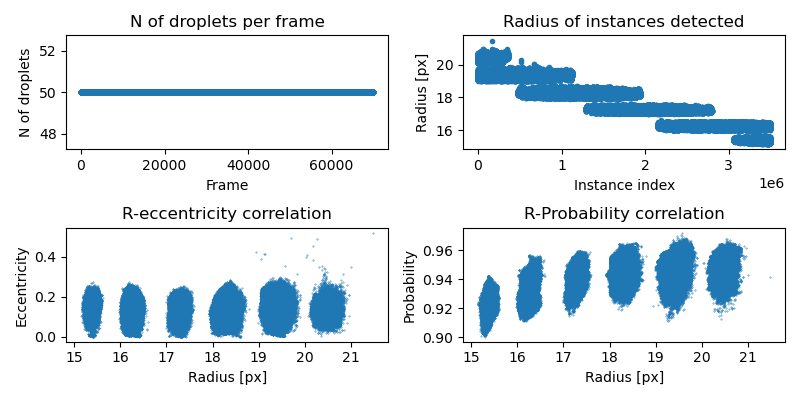

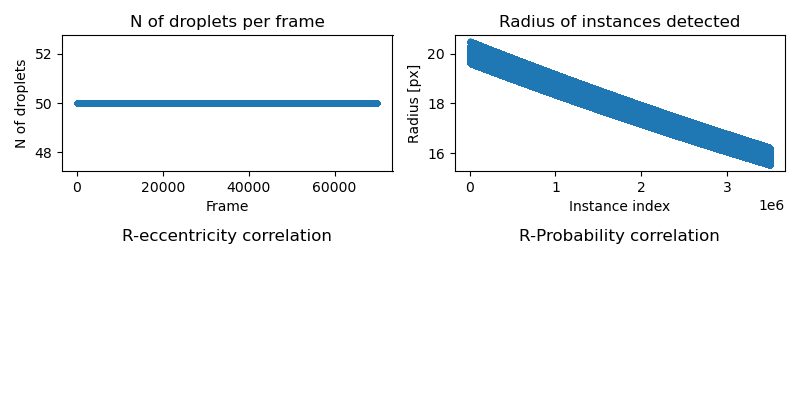

In [4]:
n_feature_per_frame = raw_detection_df.groupby('frame').count().x.values
fig, ax = plt.subplots(2, 2, figsize = (8, 4))
ax[0, 0].plot(raw_detection_df.frame.unique(), n_feature_per_frame, '.')
ax[0, 0].set(xlabel = 'Frame', ylabel = 'N of droplets', title = 'N of droplets per frame')
ax[0, 1].plot(raw_detection_df.r, '.')
ax[0, 1].set(xlabel = 'Instance index', ylabel = 'Radius [px]', title = 'Radius of instances detected')
ax[1, 0].scatter(raw_detection_df.r, raw_detection_df.eccentricity, s=0.1)
ax[1, 0].set(xlabel = 'Radius [px]', ylabel='Eccentricity', title='R-eccentricity correlation')
ax[1, 1].scatter(raw_detection_df.r, raw_detection_df.prob, s=0.1)
ax[1, 1].set(xlabel = 'Radius [px]', ylabel='Probability', title='R-Probability correlation')
plt.tight_layout()
plt.show()

n_feature_per_frame = simulated_trajectories.groupby('frame').count().x.values
fig, ax = plt.subplots(2, 2, figsize = (8, 4))
ax[0, 0].plot(simulated_trajectories.frame.unique(), n_feature_per_frame, '.')
ax[0, 0].set(xlabel = 'Frame', ylabel = 'N of droplets', title = 'N of droplets per frame')
ax[0, 1].plot(simulated_trajectories.r, '.')
ax[0, 1].set(xlabel = 'Instance index', ylabel = 'Radius [px]', title = 'Radius of instances detected')
ax[1, 0].axis('off')
ax[1, 0].set(xlabel = 'Radius [px]', ylabel='Eccentricity', title='R-eccentricity correlation')
ax[1, 1].axis('off')
ax[1, 1].set(xlabel = 'Radius [px]', ylabel='Probability', title='R-Probability correlation')
plt.tight_layout()
plt.show()

In [6]:
if run_linking_verb:
    print('Linking stardist_trajectories...')
    cutoff = 100
    t = tp.link_df(raw_detection_df, cutoff, memory = 1, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
    #print(t)
    t = t.sort_values(['frame', 'particle'])
    stardist_trajectories = t#tp.filter_stubs(t, 25)
    # CREATE COLOR COLUMN AND SAVE DF
    n = max(stardist_trajectories.particle)
    print(f'N of droplets: {n + 1}')
    random.seed(5)
    colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
    for i in range(max(stardist_trajectories.particle)+1-n):
        colors.append('#00FFFF')
    c = []
    for p in t.particle:
        c.append(colors[p])
    stardist_trajectories['color'] = c
    stardist_trajectories = stardist_trajectories.reset_index(drop=True)
    stardist_trajectories.to_parquet(f'./simulation/stardist_trajectories_{fps}_fps_r_decay_r_gaussian2.parquet')
else:
    stardist_trajectories = pd.read_parquet(f'./simulation/stardist_trajectories_{fps}_fps_r_decay_r_gaussian2.parquet')

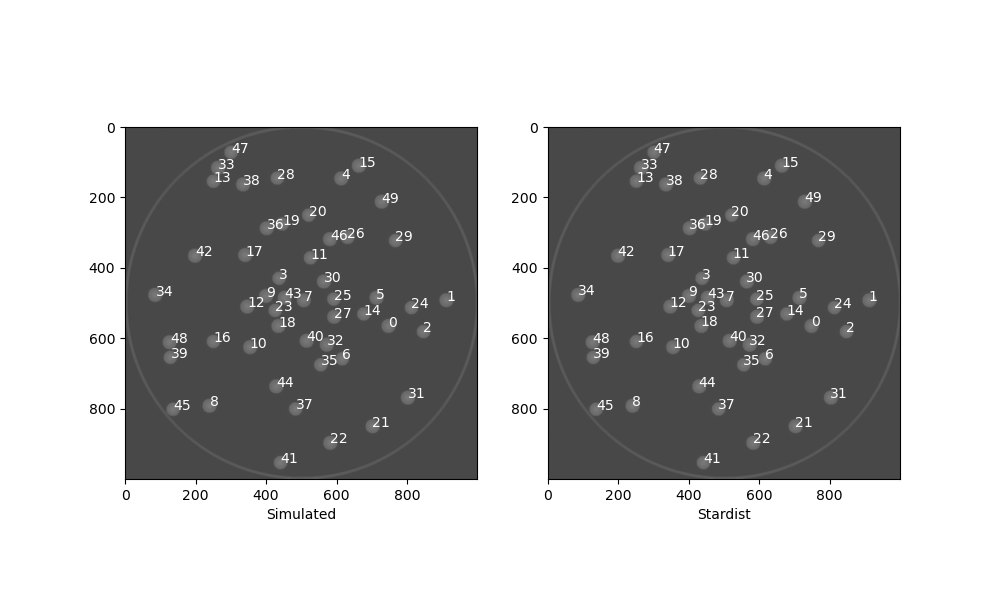

In [7]:
# match simulated and stardist trajectories particle ids
dist_matrix = scipy.spatial.distance_matrix(stardist_trajectories.loc[stardist_trajectories.frame == 0 ,['x','y']], simulated_trajectories.loc[simulated_trajectories.frame == 0, ['x','y']])                                    
id_assignment = scipy.optimize.linear_sum_assignment(dist_matrix)
stardist_trajectories['particle'] = np.array([id_assignment[1] for i in range(len(frames))]).flatten()
stardist_trajectories = stardist_trajectories.sort_values(['frame', 'particle'])
simulated_trajectories = simulated_trajectories.sort_values(['frame', 'particle'])

df1 = simulated_trajectories.loc[simulated_trajectories.frame == 0]
df2 = stardist_trajectories.loc[stardist_trajectories.frame == 0]
img = imread(imgs_path + f'frame_{0}_{resolution}_resolution.tif')

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 6))
ax.imshow(img, cmap='gray', vmin = 0, vmax = 255)
for i in range(len(df1)):
    ax.text(df1.iloc[i].x, df1.iloc[i].y, str(int(df1.iloc[i].particle)), color = 'w')
ax.set(xlabel = 'Simulated')
ax1.imshow(img, cmap='gray', vmin = 0, vmax = 255)
for i in range(len(df2)):
    ax1.text(df2.iloc[i].x, df2.iloc[i].y, str(df2.iloc[i].particle), color = 'w')
ax1.set(xlabel = 'Stardist')
plt.show()

# VARY SUBSAMPLE FACTOR

In [8]:
turn_angles_bins = np.linspace(-np.pi, np.pi, 201)
speed_bins = np.arange(0, 100, .2)

In [12]:
simulated_positions.shape

(2800, 50, 2)

In [10]:
subsample_factor_list = np.array([1, 2, 4, 5, 10, 20, 25])
smoothing_window_list = np.arange(7, 20, 1)

smoothing_polyorder = 5

MSE = np.zeros(len(subsample_factor_list))
MSE_turn_angles = np.zeros(len(subsample_factor_list))
MSE_speed = np.zeros(len(subsample_factor_list))

MSE_smooth = np.zeros((len(subsample_factor_list), len(smoothing_window_list)))
MSE_turn_angles_smooth = np.zeros((len(subsample_factor_list), len(smoothing_window_list)))
MSE_speed_smooth = np.zeros((len(subsample_factor_list), len(smoothing_window_list)))

i = 0
for subsample_factor in tqdm(subsample_factor_list):
    simulated_trajectories_subsampled = simulated_trajectories.loc[simulated_trajectories.frame % subsample_factor == 0]
    stardist_trajectories_subsampled = stardist_trajectories.loc[stardist_trajectories.frame % subsample_factor == 0]

    simulated_positions = simulated_trajectories_subsampled.loc[:, ['x', 'y']].values.reshape(len(simulated_trajectories_subsampled.frame.unique()), 50, 2)
    stardist_positions = stardist_trajectories_subsampled.loc[:, ['x', 'y']].values.reshape(len(stardist_trajectories_subsampled.frame.unique()), 50, 2) 
    MSE[i] = np.mean((simulated_positions - stardist_positions)**2)

    simulation_turning_angles = ys.turning_angles_ensemble(get_trajs(50, simulated_trajectories_subsampled, int(fps/subsample_factor), 1), centered = True)
    simulation_turning_angles_counts, _ = np.histogram(simulation_turning_angles, bins = turn_angles_bins, density = True)
    stardist_turning_angles = ys.turning_angles_ensemble(get_trajs(50, stardist_trajectories_subsampled, int(fps/subsample_factor), 1), centered = True)
    stardist_turning_angles_counts, _ = np.histogram(stardist_turning_angles, bins = turn_angles_bins, density = True)
    MSE_turn_angles[i] = np.mean((simulation_turning_angles_counts - stardist_turning_angles_counts)**2)

    simulation_speed = ys.speed_ensemble(get_trajs(50, simulated_trajectories_subsampled, int(fps/subsample_factor), 1), step=1)
    simulation_speed_counts, _ = np.histogram(simulation_speed, bins = speed_bins, density = True)
    stardist_speed = ys.speed_ensemble(get_trajs(50, stardist_trajectories_subsampled, int(fps/subsample_factor), 1), step=1)
    stardist_speed_counts, _ = np.histogram(stardist_speed, bins = speed_bins, density = True)
    MSE_speed[i] = np.mean((simulation_speed_counts - stardist_speed_counts)**2)

    # smooth trajectories
    j = 0
    for wind in smoothing_window_list:
        smoooth_stardist_trajectories = get_smooth_trajs(stardist_trajectories_subsampled, wind, smoothing_polyorder)

        smooth_stardist_positions = smoooth_stardist_trajectories.loc[:, ['x', 'y']].values.reshape(len(smoooth_stardist_trajectories.frame.unique()), 50, 2)
        MSE_smooth[i, j] = np.mean((simulated_positions - smooth_stardist_positions)**2)

        stardist_turning_angles_smooth = ys.turning_angles_ensemble(get_trajs(50, smoooth_stardist_trajectories, int(fps/subsample_factor), 1), centered = True)
        stardist_turning_angles_smooth_counts, _ = np.histogram(stardist_turning_angles_smooth, bins = turn_angles_bins, density = True)
        MSE_turn_angles_smooth[i, j] = np.mean((simulation_turning_angles_counts - stardist_turning_angles_smooth_counts)**2)

        stardist_speed_smooth = ys.speed_ensemble(get_trajs(50, smoooth_stardist_trajectories, int(fps/subsample_factor), 1), step=1)
        stardist_speed_counts_smooth, _ = np.histogram(stardist_speed_smooth, bins = speed_bins, density = True)
        MSE_speed_smooth[i, j] = np.mean((simulation_speed_counts - stardist_speed_counts_smooth)**2)
        
        j += 1
    i += 1

100%|██████████| 7/7 [01:52<00:00, 16.09s/it]


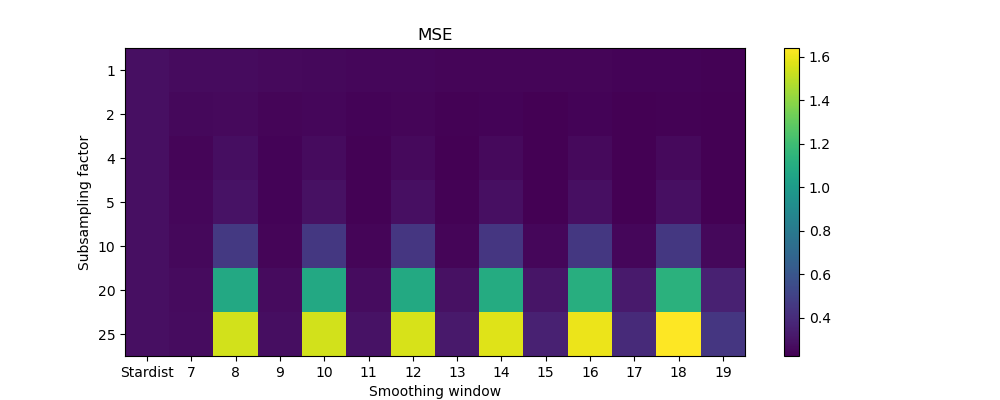

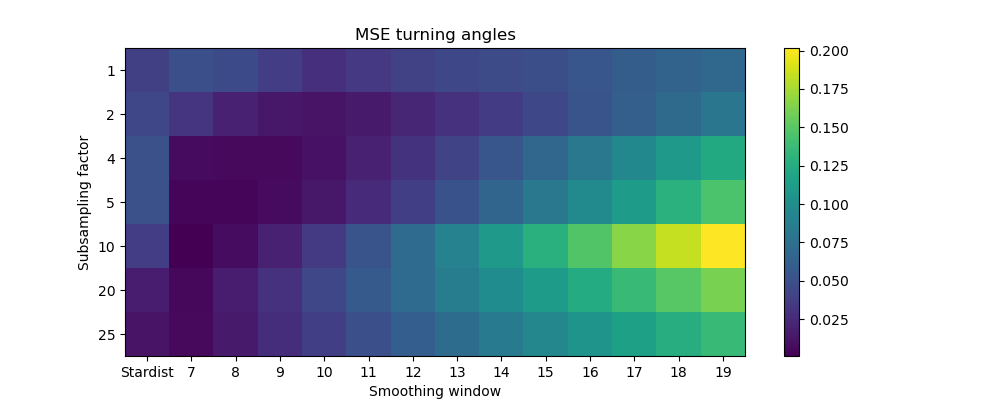

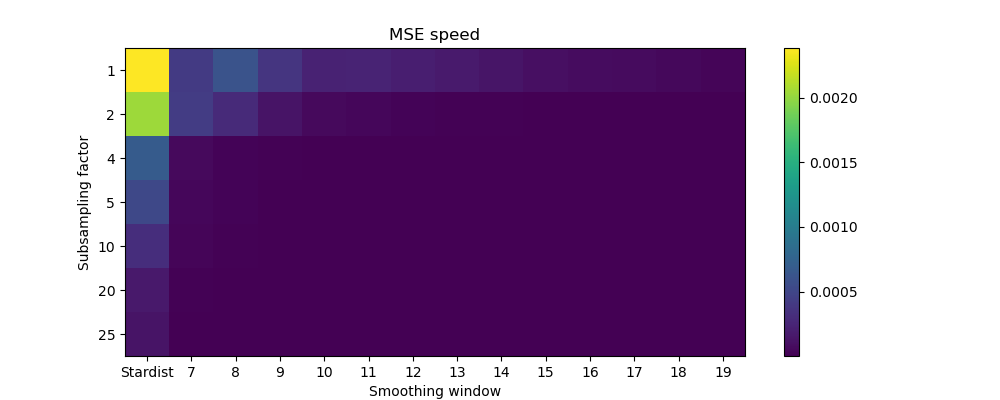

In [11]:
MSE_full = np.concatenate((MSE.reshape(len(MSE), 1), MSE_smooth), axis = 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
img = ax.imshow(MSE_full, aspect = 'auto')
ax.set(xlabel = 'Smoothing window', ylabel = 'Subsampling factor', title = 'MSE')
ax.set(xticks = np.arange(len(smoothing_window_list)+1), xticklabels = ['Stardist'] + [str(i) for i in smoothing_window_list])
ax.set(yticks = np.arange(len(subsample_factor_list)), yticklabels = subsample_factor_list)
plt.colorbar(img)
plt.show()

MSE_turn_angles_full = np.concatenate((MSE_turn_angles.reshape(len(MSE_turn_angles), 1), MSE_turn_angles_smooth), axis = 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
img = ax.imshow(MSE_turn_angles_full, aspect = 'auto')
ax.set(xlabel = 'Smoothing window', ylabel = 'Subsampling factor', title = 'MSE turning angles')
ax.set(xticks = np.arange(len(smoothing_window_list)+1), xticklabels = ['Stardist'] + [str(i) for i in smoothing_window_list])
ax.set(yticks = np.arange(len(subsample_factor_list)), yticklabels = subsample_factor_list)
plt.colorbar(img)
plt.show()

MSE_speed_full = np.concatenate((MSE_speed.reshape(len(MSE_speed), 1), MSE_speed_smooth), axis = 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
img = ax.imshow(MSE_speed_full, aspect = 'auto')
ax.set(xlabel = 'Smoothing window', ylabel = 'Subsampling factor', title = 'MSE speed')
ax.set(xticks = np.arange(len(smoothing_window_list)+1), xticklabels = ['Stardist'] + [str(i) for i in smoothing_window_list])
ax.set(yticks = np.arange(len(subsample_factor_list)), yticklabels = subsample_factor_list)
plt.colorbar(img)
plt.show()

MSE: 0.27956603982838646
MSE_smooth: 0.261093229564796
MSE_turn_angles: 0.039092773833386586
MSE_turn_angles_smooth: 0.019232636975292552
MSE_speed: 0.0023847687033404646
MSE_speed_smooth: 0.0002654662003599035


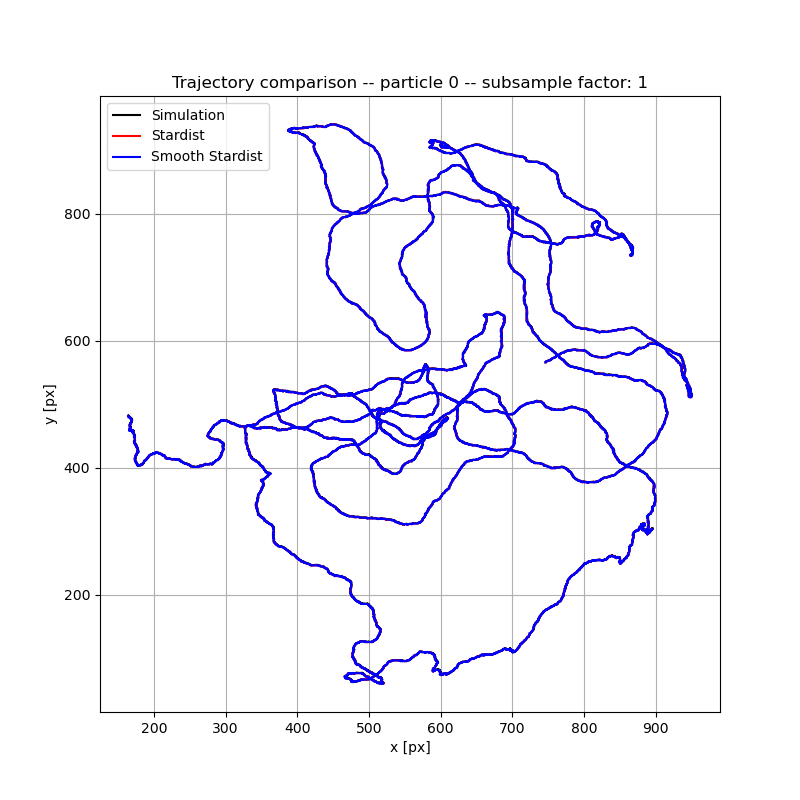

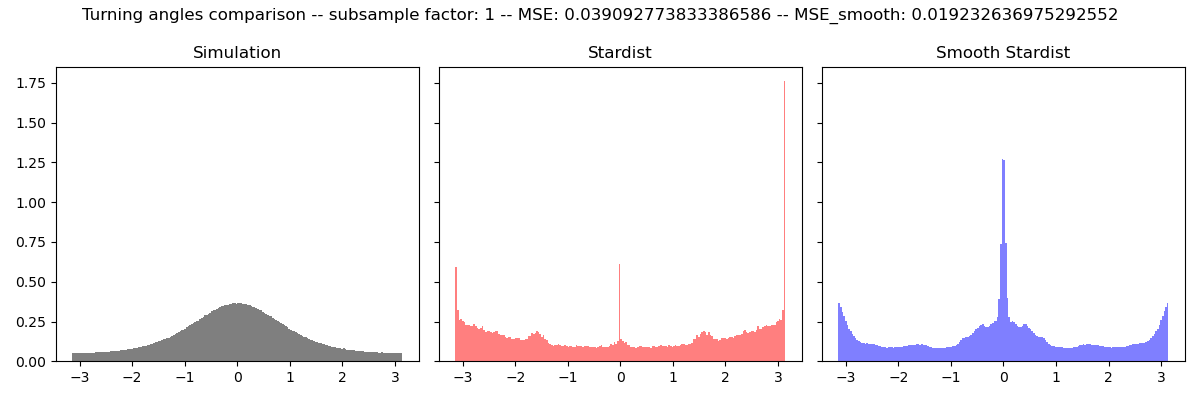

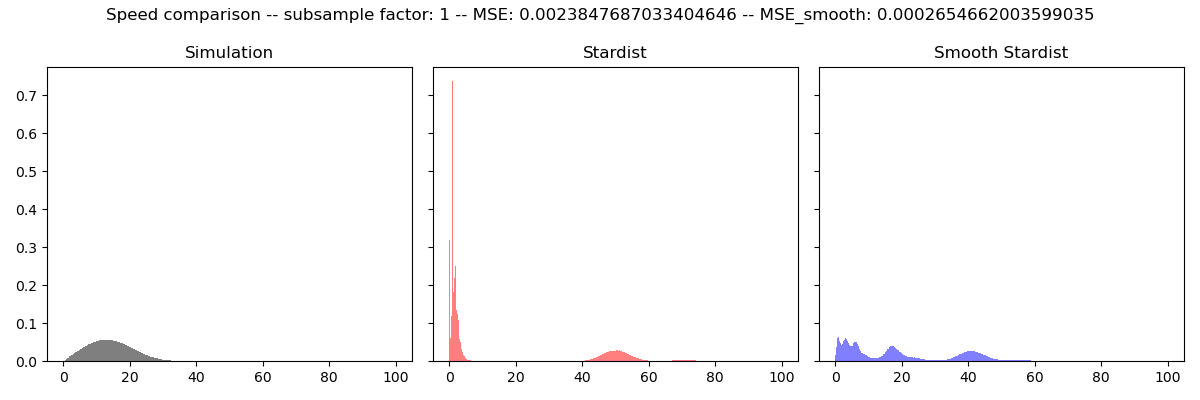

In [14]:
subsample_factor = 1
smoothing_window = 11
smoothing_polyorder = 6

simulated_trajectories_subsampled = simulated_trajectories.loc[simulated_trajectories.frame % subsample_factor == 0]
stardist_trajectories_subsampled = stardist_trajectories.loc[stardist_trajectories.frame % subsample_factor == 0]
smoooth_stardist_trajectories = get_smooth_trajs(stardist_trajectories_subsampled, smoothing_window, smoothing_polyorder)

# positions 
simulated_positions = simulated_trajectories_subsampled.loc[:, ['x', 'y']].values.reshape(len(simulated_trajectories_subsampled.frame.unique()), 50, 2)
stardist_positions = stardist_trajectories_subsampled.loc[:, ['x', 'y']].values.reshape(len(stardist_trajectories_subsampled.frame.unique()), 50, 2) 
smooth_stardist_positions = smoooth_stardist_trajectories.loc[:, ['x', 'y']].values.reshape(len(smoooth_stardist_trajectories.frame.unique()), 50, 2)
MSE_best = np.mean((simulated_positions - stardist_positions)**2)
MSE_smooth_best = np.mean((simulated_positions - smooth_stardist_positions)**2)

print(f'MSE: {MSE_best}')
print(f'MSE_smooth: {MSE_smooth_best}')

# turning angles
simulation_turning_angles = ys.turning_angles_ensemble(get_trajs(50, simulated_trajectories_subsampled, 30, 1), centered = True)
simulation_turning_angles_counts, _ = np.histogram(simulation_turning_angles, bins = turn_angles_bins, density = True)
stardist_turning_angles = ys.turning_angles_ensemble(get_trajs(50, stardist_trajectories_subsampled, 30, 1), centered = True)
stardist_turning_angles_counts, _ = np.histogram(stardist_turning_angles, bins = turn_angles_bins, density = True)
stardist_turning_angles_smooth = ys.turning_angles_ensemble(get_trajs(50, smoooth_stardist_trajectories, 30, 1), centered = True)
stardist_turning_angles_smooth_counts, _ = np.histogram(stardist_turning_angles_smooth, bins = turn_angles_bins, density = True)
MSE_turn_angles_best = np.mean((simulation_turning_angles_counts - stardist_turning_angles_counts)**2)
MSE_turn_angles_smooth_best = np.mean((simulation_turning_angles_counts - stardist_turning_angles_smooth_counts)**2)

print(f'MSE_turn_angles: {MSE_turn_angles_best}')
print(f'MSE_turn_angles_smooth: {MSE_turn_angles_smooth_best}')

# speed
simulation_speed = ys.speed_ensemble(get_trajs(50, simulated_trajectories_subsampled, int(fps/subsample_factor), 1), step=1)
simulation_speed_counts, _ = np.histogram(simulation_speed, bins = speed_bins, density = True)
stardist_speed = ys.speed_ensemble(get_trajs(50, stardist_trajectories_subsampled, int(fps/subsample_factor), 1), step=1)
stardist_speed_counts, _ = np.histogram(stardist_speed, bins = speed_bins, density = True)
stardist_speed_smooth = ys.speed_ensemble(get_trajs(50, smoooth_stardist_trajectories, int(fps/subsample_factor), 1), step=1)
stardist_speed_counts_smooth, _ = np.histogram(stardist_speed_smooth, bins = speed_bins, density = True)
MSE_speed_best = np.mean((simulation_speed_counts - stardist_speed_counts)**2)
MSE_speed_smooth_best = np.mean((simulation_speed_counts - stardist_speed_counts_smooth)**2)

print(f'MSE_speed: {MSE_speed_best}')
print(f'MSE_speed_smooth: {MSE_speed_smooth_best}')

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(simulated_trajectories_subsampled.loc[simulated_trajectories_subsampled.particle == 0].x, simulated_trajectories_subsampled.loc[simulated_trajectories_subsampled.particle == 0].y, color = 'k', label = 'Simulation')
ax.plot(stardist_trajectories_subsampled.loc[stardist_trajectories_subsampled.particle == 0].x, stardist_trajectories_subsampled.loc[stardist_trajectories_subsampled.particle == 0].y, color = 'r', label = 'Stardist')
ax.plot(smoooth_stardist_trajectories.loc[smoooth_stardist_trajectories.particle == 0].x, smoooth_stardist_trajectories.loc[smoooth_stardist_trajectories.particle == 0].y, color = 'b', label = 'Smooth Stardist')
ax.set(xlabel = 'x [px]', ylabel = 'y [px]', title = f'Trajectory comparison -- particle 0 -- subsample factor: {subsample_factor}')
ax.legend()
ax.grid()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].hist(simulation_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, color = 'k', label = 'Simulation')
ax[1].hist(stardist_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, color = 'r', label = 'Stardist')
ax[2].hist(stardist_turning_angles_smooth, bins = turn_angles_bins, density = True, alpha = 0.5, color = 'b', label = 'Smooth Stardist')
ax[0].set(title = 'Simulation')
ax[1].set(title = 'Stardist')
ax[2].set(title = 'Smooth Stardist')
plt.suptitle(f'Turning angles comparison -- subsample factor: {subsample_factor} -- MSE: {MSE_turn_angles_best} -- MSE_smooth: {MSE_turn_angles_smooth_best}')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].hist(simulation_speed, bins = speed_bins, density = True, alpha = 0.5, color = 'k', label = 'Simulation')
ax[1].hist(stardist_speed, bins = speed_bins, density = True, alpha = 0.5, color = 'r', label = 'Stardist')
ax[2].hist(stardist_speed_smooth, bins = speed_bins, density = True, alpha = 0.5, color = 'b', label = 'Smooth Stardist')
ax[0].set(title = 'Simulation')
ax[1].set(title = 'Stardist')
ax[2].set(title = 'Smooth Stardist')
plt.suptitle(f'Speed comparison -- subsample factor: {subsample_factor} -- MSE: {MSE_speed_best} -- MSE_smooth: {MSE_speed_smooth_best}')
plt.tight_layout()
plt.show()

(349900,)

# BUH

In [ ]:
subsample = False
if subsample:
    simulated_trajectories2 = simulated_trajectories.loc[simulated_trajectories.frame.isin(simulated_trajectories.frame.unique()[::3])]
    stardist_trajectories2 = stardist_trajectories.loc[stardist_trajectories.frame.isin(stardist_trajectories.frame.unique()[::3])]
else:
    simulated_trajectories2 = simulated_trajectories
    stardist_trajectories2 = stardist_trajectories

In [ ]:
for polyorder in range(2, 10):
    windList = np.append(0, np.arange(polyorder + 1, 50, 1))
    MSE = np.zeros(len(windList))
    MSE_turn_angles = np.zeros(len(windList))
    MSE_speed = np.zeros(len(windList))

    simulated_positions = simulated_trajectories2.loc[:, ['x', 'y']].values.reshape(len(simulated_trajectories2.frame.unique()), 50, 2)
    stardist_positions = stardist_trajectories2.loc[:, ['x', 'y']].values.reshape(len(stardist_trajectories2.frame.unique()), 50, 2) 
    MSE[0] = np.mean((simulated_positions - stardist_positions)**2)

    simulation_turning_angles = ys.turning_angles_ensemble(get_trajs(50, simulated_trajectories2, 30, 1), centered = True)
    simulation_turning_angles_counts, _ = np.histogram(simulation_turning_angles, bins = turn_angles_bins, density = True)
    stardist_turning_angles = ys.turning_angles_ensemble(get_trajs(50, stardist_trajectories2, 30, 1), centered = True)
    stardist_turning_angles_counts, _ = np.histogram(stardist_turning_angles, bins = turn_angles_bins, density = True)
    MSE_turn_angles[0] = np.mean((simulation_turning_angles_counts - stardist_turning_angles_counts)**2)

    simulation_speed = ys.speed_ensemble(get_trajs(50, simulated_trajectories2, 30, 1), step=1)
    simulation_speed_counts, _ = np.histogram(simulation_speed, bins = speed_bins, density = True)
    stardist_speed = ys.speed_ensemble(get_trajs(50, stardist_trajectories2, 30, 1), step=1)
    stardist_speed_counts, _ = np.histogram(stardist_speed, bins = speed_bins, density = True)
    MSE_speed[0] = np.mean((simulation_speed_counts - stardist_speed_counts)**2)

    i = 1
    for wind in tqdm(windList[1:]):
        stardist_smooth_trajs = get_smooth_trajs(stardist_trajectories2, wind, polyorder)
        smoooth_stardist_positions = stardist_smooth_trajs.loc[:, ['x', 'y']].values.reshape(len(stardist_smooth_trajs.frame.unique()), 50, 2)
        MSE[i] = np.mean((simulated_positions - smoooth_stardist_positions)**2)
        
        smooth_stardist_turning_angles = ys.turning_angles_ensemble(get_trajs(50, stardist_smooth_trajs, 30, 1), centered= True)
        smooth_stardistis_turning_angles_counts, _ = np.histogram(smooth_stardist_turning_angles, bins = turn_angles_bins, density = True)
        MSE_turn_angles[i] = np.mean((simulation_turning_angles_counts - smooth_stardistis_turning_angles_counts)**2)

        smooth_stardist_speed = ys.speed_ensemble(get_trajs(50, stardist_smooth_trajs, 30, 1), step=1)
        smooth_stardistis_speed_counts, _ = np.histogram(smooth_stardist_speed, bins = speed_bins, density = True)

        MSE_speed[i] = np.mean((simulation_speed_counts - smooth_stardistis_speed_counts)**2)
        i += 1

    fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize = (14, 5))
    ax.plot(windList, MSE_turn_angles)
    ax.set(xlabel = 'Window size', ylabel = 'MSE', title = 'MSE of turning angles')
    ax.grid()
    ax1.plot(windList, MSE)
    ax1.set(xlabel = 'Window size', ylabel = 'MSE', title = 'MSE of positions')
    ax1.grid()
    ax1.set(ylim = (0, 1))
    ax2.plot(windList, MSE_speed)
    ax2.set(xlabel = 'Window size', ylabel = 'MSE', title = 'MSE of speed')
    ax2.grid()
    plt.suptitle(f'MSE of stardist smoothet with polynomial order: {polyorder}')
    plt.tight_layout()
    if subsample:
        plt.savefig(f'./simulation/smoothing_analysis/stardist_smoothed_MSE_polyorder_{polyorder}.png')
    else:
        plt.savefig(f'./simulation/smoothing_analysis/stardist_smoothed_MSE_polyorder_{polyorder}.png')
    plt.close()

In [ ]:
simulation_turning_angles = ys.turning_angles_ensemble(get_trajs(50, simulated_trajectories, 30, 1), centered = True)
simulation_turning_angles_counts, _ = np.histogram(simulation_turning_angles, bins = turn_angles_bins, density = True)
simulation_speed = ys.speed_ensemble(get_trajs(50, simulated_trajectories, 30, 1), step=1)
simulation_speed_counts, _ = np.histogram(simulation_speed, bins = speed_bins, density = True)

In [23]:
np.sqrt(2 * 0.1 * 0.01)

0.044721359549995794

In [17]:
import trackpy as tp

tp.

0.1

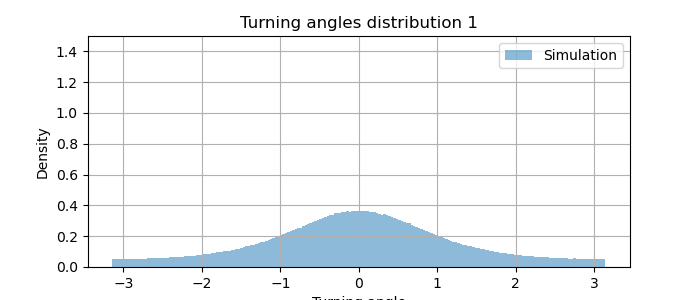

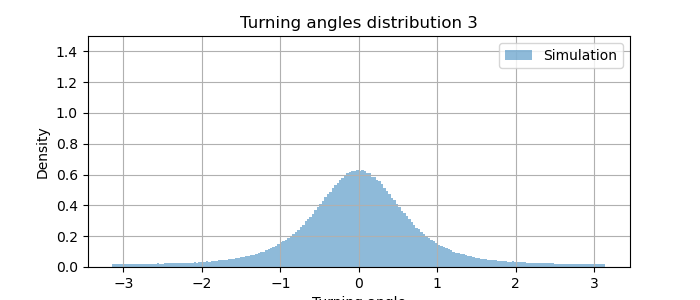

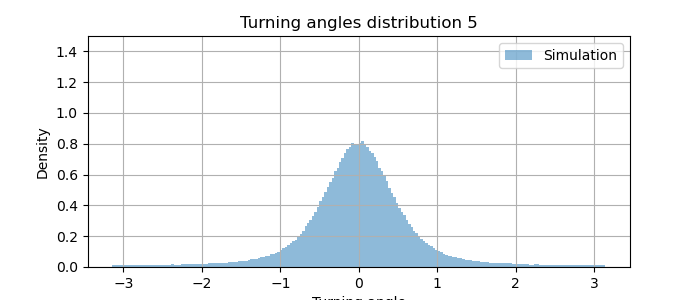

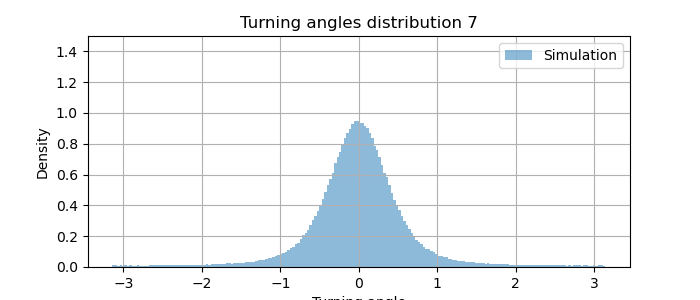

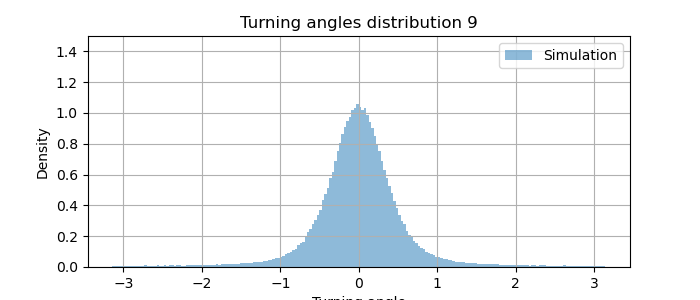

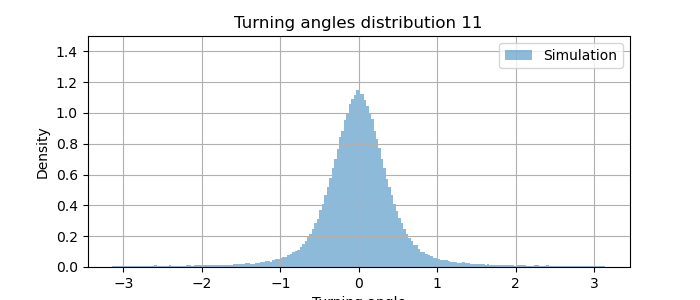

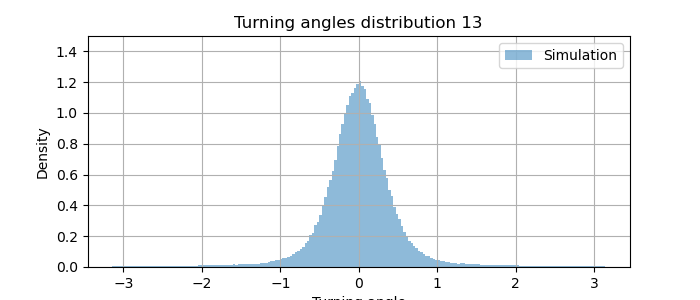

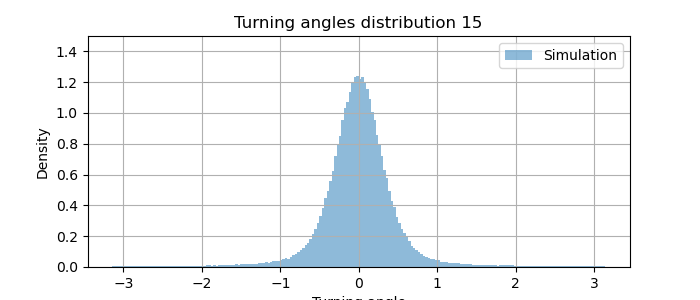

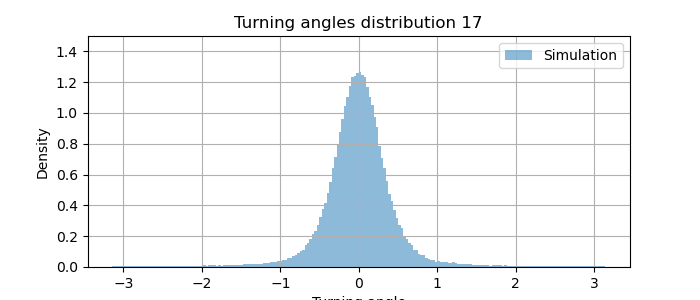

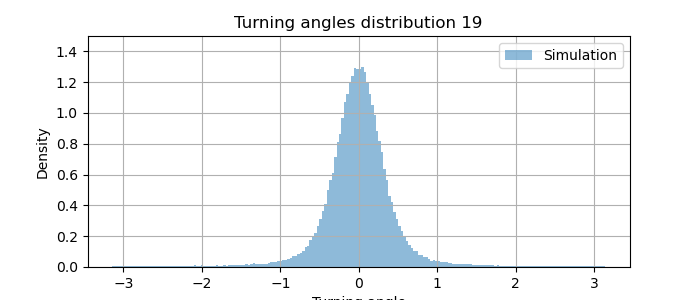

In [21]:
for i in range(1, 20, 2):
    simulated_trajectories2 = simulated_trajectories.loc[simulated_trajectories.frame.isin(simulated_trajectories.frame.unique()[::i])]
    simulation_turning_angles = ys.turning_angles_ensemble(get_trajs(50, simulated_trajectories2, 30, 1), centered = True)
    fig, ax = plt.subplots(1, 1, figsize=(7, 3))
    ax.hist(simulation_turning_angles, bins = turn_angles_bins, density = True, alpha = .5, label = 'Simulation')
    ax.set(title = f'Turning angles distribution {i}', xlabel = 'Turning angle', ylabel = 'Density', ylim = (0, 1.5))
    ax.legend()
    ax.grid()
    plt.show()

In [ ]:
if subsample:
    stardist_smooth_trajs = get_smooth_trajs(stardist_trajectories2, windLen = 10, orderofPoly = 4)
else:
    stardist_smooth_trajs = get_smooth_trajs(stardist_trajectories2, windLen = 15, orderofPoly = 6)
smooth_stardist_speed = ys.speed_ensemble(get_trajs(50, stardist_smooth_trajs, 30, 1), step=1)
smooth_stardist_turning_angles = ys.turning_angles_ensemble(get_trajs(50, stardist_smooth_trajs, 30, 1), centered = True)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(simulated_trajectories2.loc[simulated_trajectories2.particle == 0].x, simulated_trajectories2.loc[simulated_trajectories2.particle == 0].y, color = 'k', label = 'Simulation')
ax.plot(stardist_trajectories2.loc[stardist_trajectories2.particle == 0].x, stardist_trajectories2.loc[stardist_trajectories2.particle == 0].y, color = 'r', label = 'Stardist')
ax.plot(stardist_smooth_trajs.loc[stardist_smooth_trajs.particle == 0].x, stardist_smooth_trajs.loc[stardist_smooth_trajs.particle == 0].y, label = 'Stardist smooth', color = 'b')
ax.legend()
ax.grid()
if subsample:
    plt.savefig(f'./simulation/smoothing_analysis_subsample/stardist_smoothed_trajectory_example.png')
else:
    plt.savefig(f'./simulation/smoothing_analysis/stardist_smoothed_trajectories.png')
plt.show()

fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 4), sharex=True, sharey=True)
ax.hist(stardist_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Stardist', color = 'r')
ax1.hist(smooth_stardist_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Stardist smooth', color = 'b')
ax2.hist(simulation_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Simulation', color = 'k')
ax.set(xlabel = 'Turning angle', ylabel = 'pdf')
ax1.set(xlabel = 'Turning angle', ylabel = 'pdf')
ax2.set(xlabel = 'Turning angle', ylabel = 'pdf')
ax.legend()
ax1.legend()
ax2.legend()
if subsample:
    plt.savefig(f'./simulation/smoothing_analysis_subsample/stardist_smoothed_turning_angles.png')
else:
    plt.savefig(f'./simulation/smoothing_analysis/stardist_smoothed_turning_angles.png')
plt.show()

fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax.hist(stardist_speed, bins = speed_bins, density = True, alpha = 0.5, label = 'Stardist', color = 'r')
ax1.hist(smooth_stardist_speed, bins = speed_bins, density = True, alpha = 0.5, label = 'Stardist smooth', color = 'b')
ax2.hist(simulation_speed, bins = speed_bins, density = True, alpha = 0.5, label = 'Simulation', color = 'k')
ax.set(xlabel = 'Speed', ylabel = 'pdf')
ax1.set(xlabel = 'Speed', ylabel = 'pdf')
ax2.set(xlabel = 'Speed', ylabel = 'pdf')
ax.legend()
ax1.legend()
ax2.legend()
if subsample:
    plt.savefig(f'./simulation/smoothing_analysis_3_subsample/stardist_smoothed_speed.png')
else:
    plt.savefig(f'./simulation/smoothing_analysis/stardist_smoothed_speed.png')
plt.show()

In [ ]:
# Histogram fit
def fit_hist(y, bins_, distribution, p0_):
    bins_c = bins_[:-1] + np.diff(bins_) / 2
    bin_heights, _ = np.histogram(y, bins = bins_, density = True)
    ret, pcov = curve_fit(distribution, bins_c, bin_heights, p0 = p0_, maxfev = 1000)
    ret_std = np.sqrt(np.diag(pcov))
    return ret, ret_std

# 2D Maxwell-Boltzmann distribution
def MB_2D(v, sigma):
    return v/(sigma**2) * np.exp(-v**2/(2*sigma**2))


# Generalized 2D Maxwell-Boltzmann distribution
def MB_2D_generalized(v, sigma, beta, A):
    return A*v * np.exp(-v**beta/(2*sigma**beta))


# Normal distribution
def normal_distr(x, sigma, mu):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((x-mu)/sigma)**2)


# Lorentzian distribution
def lorentzian_distr(x, gamma, x0):
    return 1/np.pi * gamma / ((x-x0)**2 + gamma**2)

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
simulation_turning_angles = ys.turning_angles_ensemble(get_trajs(50, simulated_trajectories2, 30, 1), centered = True)
stardist_turning_angles = ys.turning_angles_ensemble(get_trajs(50, stardist_trajectories2, 30, 1), centered = True)

a, b = fit_hist(simulation_turning_angles, turn_angles_bins, normal_distr, [1., 0.])
c, d = fit_hist(stardist_turning_angles, turn_angles_bins, normal_distr, [1., 0.])

fig, (ax,ax1) = plt.subplots(1, 2, figsize=(6, 4))
ax.hist(simulation_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Simulation', color = 'k')
ax.plot(turn_angles_bins, normal_distr(turn_angles_bins, *a), label = 'Normal fit', color = 'r')
ax1.hist(stardist_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Stardist', color = 'b')
ax1.plot(turn_angles_bins, normal_distr(turn_angles_bins, *c), color = 'r')
ax1.set(xlabel = 'Turning angle', ylabel = 'pdf')
plt.show()

In [ ]:
simulation_turning_angles = ys.turning_angles_ensemble(get_trajs(50, simulated_trajectories2, 30, 1), centered = True)
stardist_turning_angles = ys.turning_angles_ensemble(get_trajs(50, stardist_trajectories2, 30, 1), centered = True)

a, b = fit_hist(simulation_turning_angles, turn_angles_bins, lorentzian_distr, [1., 0.])
c, d = fit_hist(stardist_turning_angles, turn_angles_bins, lorentzian_distr, [1., 0.])

fig, (ax,ax1) = plt.subplots(1, 2, figsize=(6, 4))
ax.hist(simulation_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Simulation', color = 'k')
ax.plot(turn_angles_bins, normal_distr(turn_angles_bins, *a), label = 'Normal fit', color = 'r')
ax1.hist(stardist_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Stardist', color = 'b')
ax1.plot(turn_angles_bins, normal_distr(turn_angles_bins, *c), color = 'r')
ax1.set(xlabel = 'Turning angle', ylabel = 'pdf')
plt.show()

In [ ]:
from scipy.stats import vonmises

simulation_turning_angles = ys.turning_angles_ensemble(get_trajs(50, simulated_trajectories2, 30, 1), centered = True)
simulation_turning_angles_counts, _ = np.histogram(simulation_turning_angles, bins = turn_angles_bins, density = True)
stardist_turning_angles = ys.turning_angles_ensemble(get_trajs(50, stardist_trajectories2, 30, 1), centered = True)
stardist_turning_angles_counts, _ = np.histogram(stardist_turning_angles, bins = turn_angles_bins, density = True)

kappa1, loc1, scale1 = vonmises.fit(simulation_turning_angles_counts, loc = 0)
print(loc1, kappa1, scale1)
kappa2, loc2, scale2 = vonmises.fit(stardist_turning_angles_counts, loc = 0)
print(loc2, kappa2, scale2)

fig, (ax,ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.hist(simulation_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Simulation', color = 'k')
ax.plot(turn_angles_bins, vonmises.pdf(loc1, kappa1, turn_angles_bins), label = 'vonmises fit', color = 'r')
ax1.hist(stardist_turning_angles, bins = turn_angles_bins, density = True, alpha = 0.5, label = 'Stardist', color = 'b')
ax1.plot(turn_angles_bins, vonmises.pdf(loc2, kappa2, turn_angles_bins))
ax1.set(xlabel = 'Turning angle', ylabel = 'pdf')
plt.show()